# Домашнее задание 3. Свёрточные и рекуррентные нейронные сети
# Королев Я.М. ИУ8-83
# 7 Вариант

В зависимости от варианта, для решения задачи используйте следующие наборы данных:

<table>
    <thead>
         <tr>
            <th colspan=1>Задача генерации</th>
            <th colspan=5>Задача классификации</th>
        </tr>
        <tr>
            <th> </th>
            <th>A</th>
            <th>B</th>
            <th>C</th>
            <th>D</th>
            <th>E</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>K</td>
            <td>1</td>
            <td>2</td>
            <td>3</td>
            <td>4</td>
            <td>5</td>
        </tr>
        <tr>
            <td>L</td>
            <td>6</td>
            <td>7</td>
            <td>8</td>
            <td>9</td>
            <td>10</td>
        </tr>
        <tr>
            <td>M</td>
            <td>11</td>
            <td>12</td>
            <td>13</td>
            <td>14</td>
            <td>15</td>
        </tr>
        <tr>
            <td>N</td>
            <td>16</td>
            <td>17</td>
            <td>18</td>
            <td>19</td>
            <td>20</td>
        </tr>
        <tr>
            <td>O</td>
            <td>21</td>
            <td>22</td>
            <td>23</td>
            <td>24</td>
            <td>25</td>
        </tr>
    </tbody>
</table>

### Наборы данных

**Задача классификации картинок**

A. [Набор данных "Fashion MNIST"](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) `torchvision.datasets.FashionMNIST train=True и False`

B. [Набор данных "Текстуры"](https://pytorch.org/vision/main/generated/torchvision.datasets.DTD.html#torchvision.datasets.DTD) `torchvision.datasets.DTD split='train' и 'test'`

C. [Набор данных "Буквы"](https://pytorch.org/vision/main/generated/torchvision.datasets.EMNIST.html#torchvision.datasets.EMNIST) `torchvision.datasets.EMNIST split=letters train=True и False`

D. [Набор данных "Кошки и собаки"](https://pytorch.org/vision/main/generated/torchvision.datasets.OxfordIIITPet.html) `torchvision.datasets.OxfordIIITPet split = 'trainval' и 'test'` (объекты разбиты по породам (всего 37 пород), нужно построить бинарный классификатор собак и кошек)

E. [Набор данных "Дорожные знаки"](https://pytorch.org/vision/main/generated/torchvision.datasets.GTSRB.html) `torchvision.datasets.GTSRB split = 'train' и 'test'`


---

**Задача генерации текстов**

K. [Набор данных "Евгений Онегин"]() `onegin.txt`

L. [Набор данных "Война и Мир"]() `war_and_piece.txt`

M. [Набор данных "Стихи"]() `stihi.csv`

N. [Набор данных "Сказки"]() `fairytales.txt`

O. [Набор данных "Новости"]() `news.txt` или https://github.com/yutkin/Lenta.Ru-News-Dataset/releases

# 0. Инициализация библиотек

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision
from torchvision import datasets, transforms
import time
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [2]:
RANDOM_SEED = 2077
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH = 64
TEMPERATURE = [0.1, 0.2, 0.4, 0.6, 0.8, 1.]


In [3]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# 1. Свёрточная нейронная сеть для классификации изображений (9 баллов)

## 1.1 Загрузка данных, разделение на train и test

Загрузите данные при помощи torchvision.datasets. Можете предусмотреть опредлённые транфсофрмации картинки, например, изменение размера до 128 px, кроп по центру в 196 px и преобразование к классу torch.Tensor:

В датасете содержится 47 классов по 120 картинок в каждом.


In [4]:
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor()
])

In [5]:
train_data = datasets.DTD('data',split = 'train', download=True, transform=transform)
test_data = datasets.DTD('data',split = 'test', download=True, transform=transform)
classes=datasets.DTD('data',split = 'train', download=True, transform=transform).classes 

In [6]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH,
    shuffle=True
)
test_loader = DataLoader(
    test_data,
    batch_size=BATCH,
    shuffle=True
)

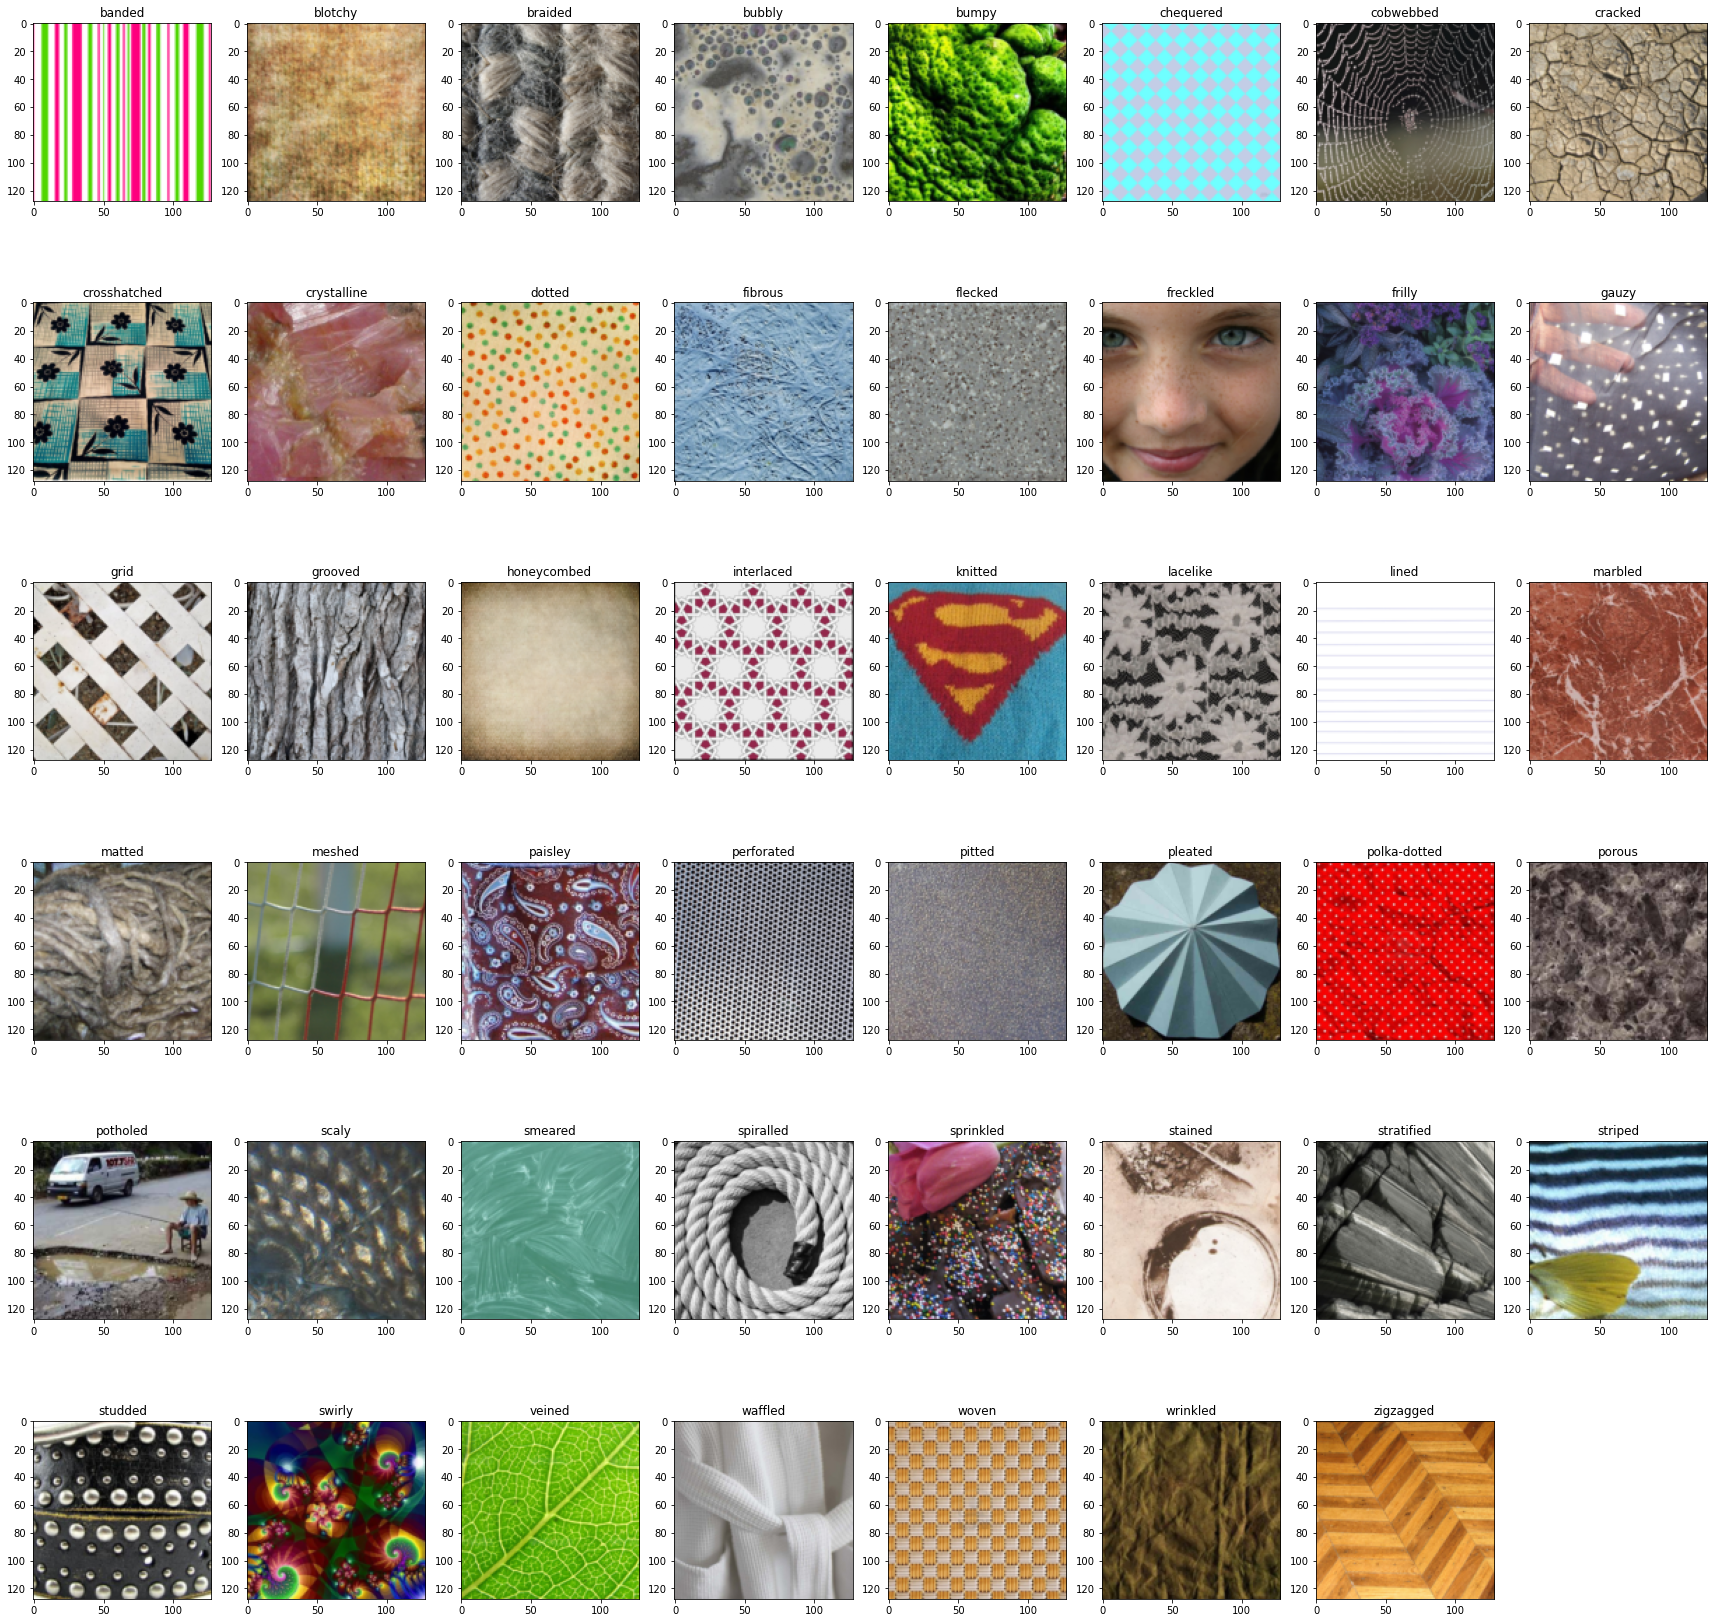

In [7]:
plt.figure(figsize=(30, 30))
for i in range(47): # кол-во классов 47
    img = train_loader.dataset[i*40][0] 
    img = img.permute(1, 2, 0)
    ax = plt.subplot(6, 8, i + 1)
    ax.title.set_text(classes[i])
    plt.imshow(img)

## 1.2 Предобработка данных (по необходимости)

## 1.3 Инициализация объекта свёрточной нейронной сети

Создайте нейронную сеть с 2-4 свёрточными слоями. В остальном конфигурация сети может быть произвольной. 

In [8]:
class ConvolutionalNetwork1(nn.Module):
  def __init__(self):
    super(ConvolutionalNetwork1, self).__init__()
    self.conv1=nn.Conv2d(3, 16, kernel_size = 3, padding = 1)
    self.conv2=nn.Conv2d(16,32, kernel_size = 3, padding = 1)
    self.conv3=nn.Conv2d(32,64, kernel_size = 3, padding = 1)
    self.conv4=nn.Conv2d(64,128, kernel_size = 3, padding = 1)
    
    self.pool=nn.MaxPool2d(2,2)

    self.linear1=nn.Linear(8*8*128,4096)
    self.linear2=nn.Linear(4096,2048)
    self.linear3=nn.Linear(2048,47)

    self.do=nn.Dropout(0.2)
    self.do_2d=nn.Dropout2d(0.2)

    self.bn1=nn.BatchNorm1d(4096)
    self.bn2=nn.BatchNorm1d(2048)

    self.flat=nn.Flatten()

  def forward(self,x):
    x=self.pool(F.relu(self.conv1(x)))
    x=self.pool(F.relu(self.conv2(x)))
    x=self.pool(F.relu(self.conv3(x)))
    x=self.pool(F.relu(self.conv4(x)))

    x=self.flat(x)

    x=F.relu(self.linear1(x))
    x=F.relu(self.linear2(x))
    x=self.linear3(x)

    return x

In [9]:
cnnNet1=ConvolutionalNetwork1().to(DEVICE)

## 1.4 Обучение сввёрточной нейронной сети для решения задачи классификации

In [10]:
def train_test_model(model, optimizer, train_dataloader,test_dataloader, epochs):
  criterion = nn.CrossEntropyLoss().to(DEVICE)
  history_acc = {'train':list(),'test':list()}
  history_loss = {'train':list(),'test':list()}

  for epoch in range(epochs):
    train_loss_list = list()
    test_loss_list = list()
    correct_train=0
    correct_test=0
    print('_________________________________________________________________________________')
    model=model.train()
    for x_batch,y_batch in train_dataloader:
      optimizer.zero_grad()
      x_batch = x_batch.to(DEVICE)
      y_batch = y_batch.to(DEVICE)
      y_pred = model(x_batch)

      loss = criterion(y_pred, y_batch)
      loss.backward()
      optimizer.step()
      train_loss_list.append(loss.item())

      predicted = torch.max(y_pred.data, 1)[1]
      correct_train += torch.sum(y_batch==predicted).item()

    model=model.eval()
    with torch.no_grad():
      for x_batch,y_batch in test_dataloader:
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        y_pred = model(x_batch)

        loss = criterion(y_pred, y_batch)
        test_loss_list.append(loss.item())

        predicted = torch.max(y_pred.data, 1)[1]
        correct_test += torch.sum(y_batch==predicted).item()

    train_loss = np.mean(train_loss_list)
    test_loss = np.mean(test_loss_list)
    history_loss['train'].append(train_loss)
    history_loss['test'].append(test_loss)

    train_acc = 100.* correct_train/len(train_dataloader.dataset)
    test_acc = 100.* correct_test/len(test_dataloader.dataset)
    history_acc['train'].append(train_acc)
    history_acc['test'].append(test_acc)

    print('Epoch: {epoch}'.format(epoch=epoch))
    print('Train accuracy: {train_accuracy} '.format(train_accuracy=train_acc))
    print('Test accuracy: {test_accuracy}'.format(test_accuracy=test_acc))
    print('Train loss: {train_loss} '.format(train_loss=train_loss))
    print('Test loss: {test_loss}'.format(test_loss=test_loss))

  return model.eval(), history_acc, history_loss

In [11]:
torch.cuda.empty_cache()
optim=torch.optim.Adam(cnnNet1.parameters(), lr=0.001)
cnnNet1,history_clf_acc,history_clf_loss=train_test_model(cnnNet1,optim,train_loader,test_loader,50)

_________________________________________________________________________________
Epoch: 0
Train accuracy: 1.8617021276595744 
Test accuracy: 2.1808510638297873
Train loss: 3.8564701239267984 
Test loss: 3.8477739334106444
_________________________________________________________________________________
Epoch: 1
Train accuracy: 2.765957446808511 
Test accuracy: 2.872340425531915
Train loss: 3.84013458887736 
Test loss: 3.810673395792643
_________________________________________________________________________________
Epoch: 2
Train accuracy: 2.765957446808511 
Test accuracy: 3.1382978723404253
Train loss: 3.7882092634836835 
Test loss: 3.77007307211558
_________________________________________________________________________________
Epoch: 3
Train accuracy: 3.9361702127659575 
Test accuracy: 3.5638297872340425
Train loss: 3.7534173170725507 
Test loss: 3.760576772689819
_________________________________________________________________________________
Epoch: 4
Train accuracy: 5.05319148

## 1.5 Агументация данных и регулряизации нейросети

Попобуйте добавить аугументацию (случайные повороты, увеличение, уменьшение) в данные, а также регуляризацию (Drop out и Batch Norm слои) в модель. Как меняется метрика accuracy на обучающей и тестовой выборке в процессе обучения? Постройте график.

In [12]:
aug_transform = transforms.Compose([
    transforms.RandomApply(transforms=[transforms.ColorJitter(brightness=0.5, hue=0.3),
                                       transforms.RandomRotation(degrees=(-45, 45)),
                                       transforms.RandomInvert(),
                                       transforms.RandomVerticalFlip(p=0.5),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomSolarize(threshold=192.0)], p=0.7),
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor()
])

In [13]:
train_data_aug = datasets.DTD('data',split = 'train', download=True, transform=aug_transform)
test_data_aug = datasets.DTD('data',split = 'test', download=True, transform=transform)
classes=datasets.DTD('data',split = 'train', download=True, transform=aug_transform).classes

In [14]:
train_data_aug=torch.utils.data.ConcatDataset([train_data_aug,train_data]) # в датасете будут обычные изображения и их аугментированные копии

In [15]:
aug_train_loader = DataLoader(
    train_data_aug,
    batch_size=BATCH,
    shuffle=True
)
aug_test_loader = DataLoader(
    test_data_aug,
    batch_size=BATCH,
    shuffle=False
)

In [16]:
len(aug_train_loader.dataset),len(train_loader.dataset)

(3760, 1880)

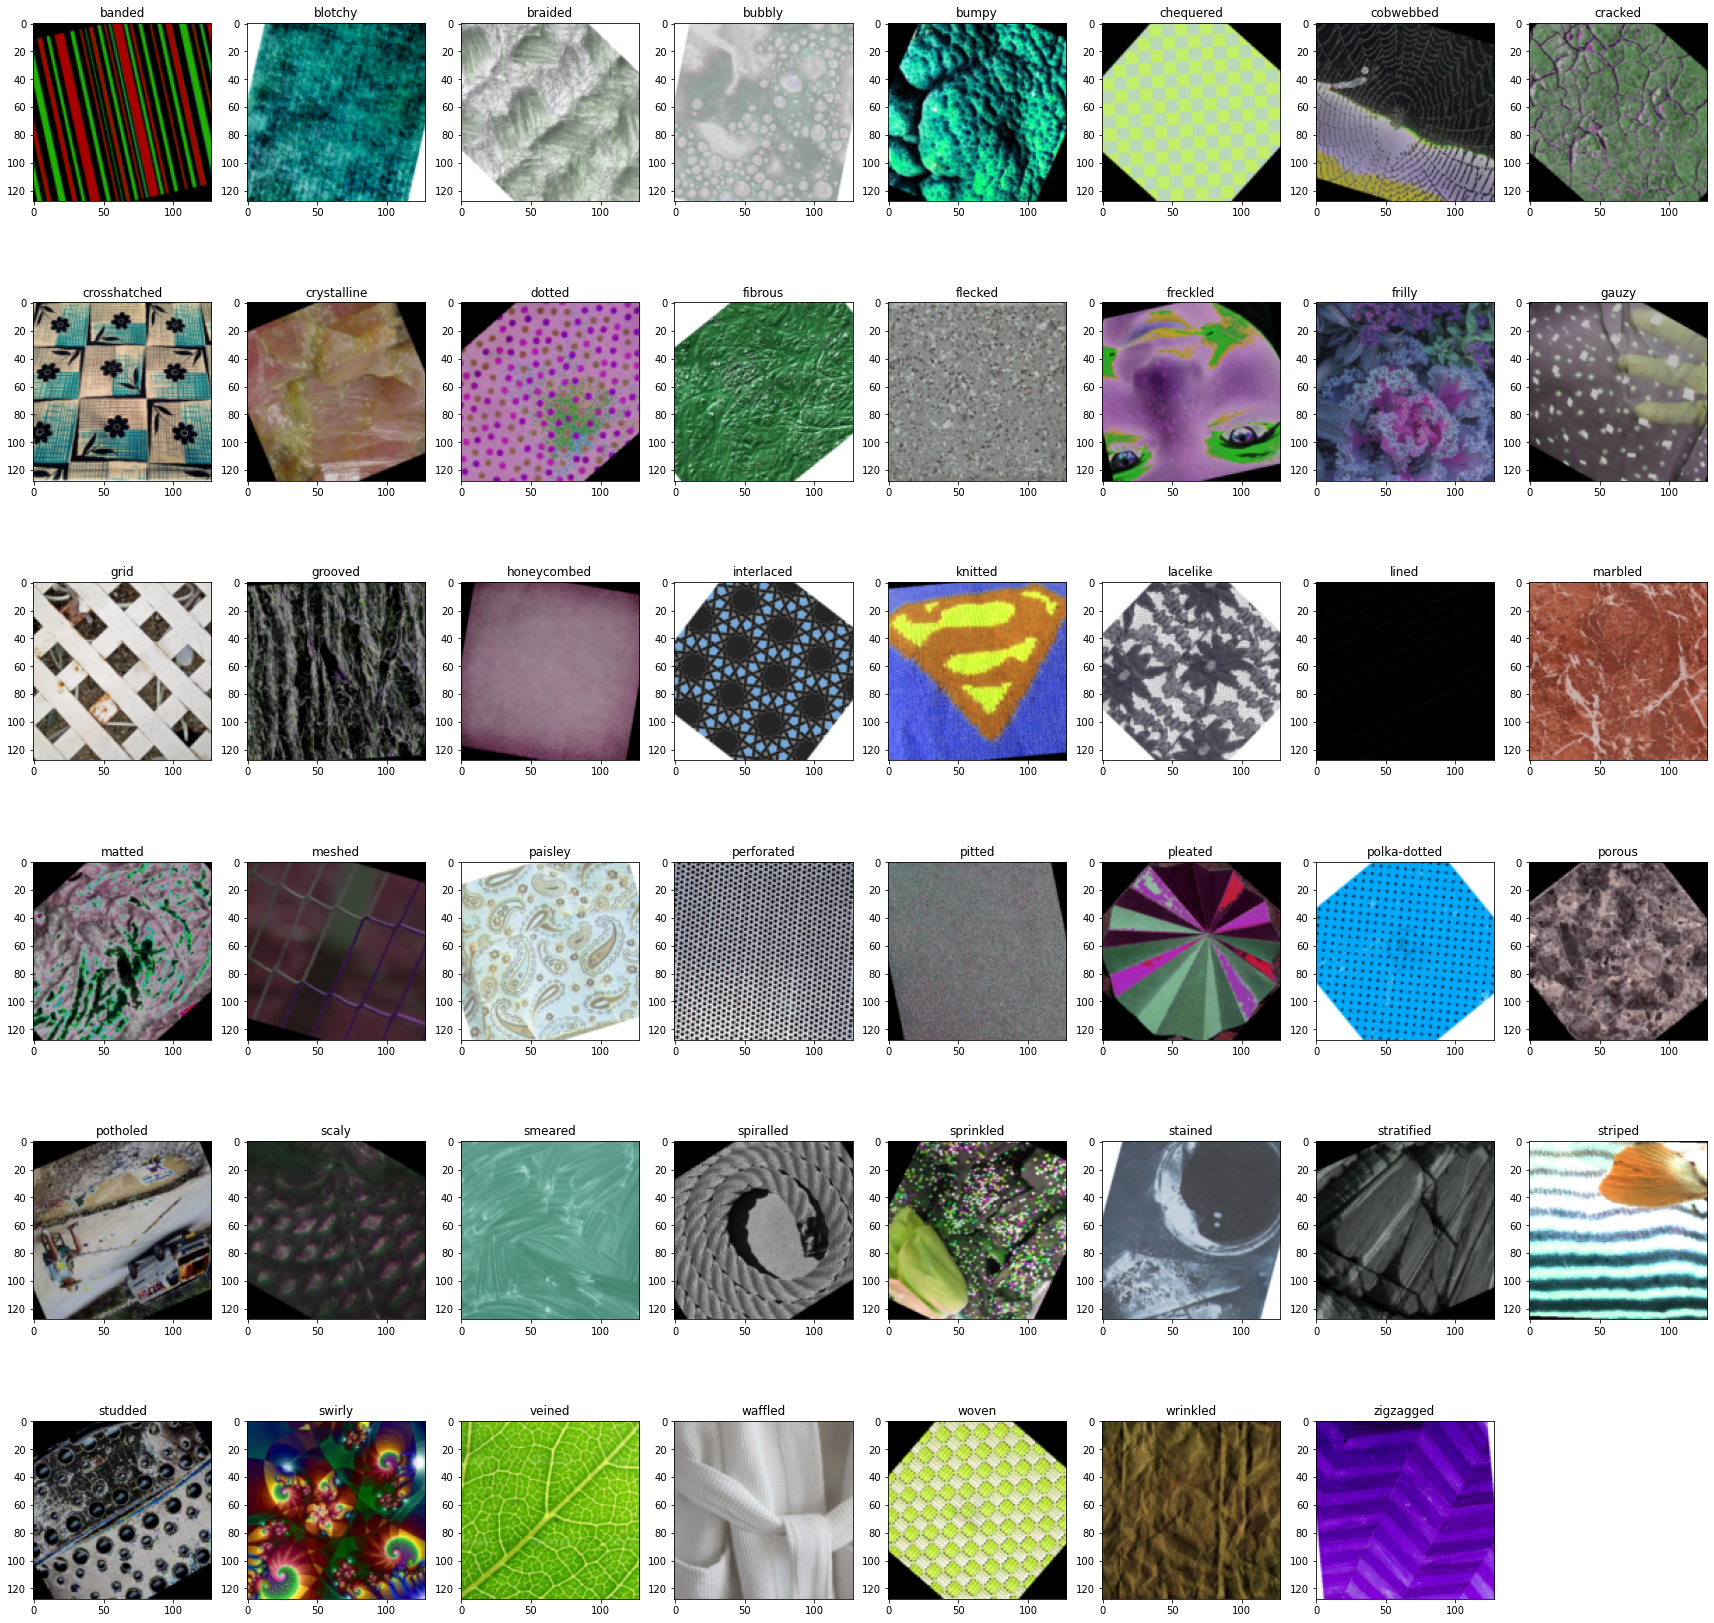

In [17]:
plt.figure(figsize=(30, 30))
for i in range(47): # кол-во классов 47
    img = aug_train_loader.dataset[i*40][0]
    img = img.permute(1, 2, 0)
    ax = plt.subplot(6, 8, i + 1)
    ax.title.set_text(classes[i])
    plt.imshow(img)
    

In [18]:
class ConvolutionalNetwork2(nn.Module):
  def __init__(self):
    super(ConvolutionalNetwork2, self).__init__()
    self.conv1=nn.Conv2d(3, 16, kernel_size = 3, padding = 1)
    self.conv2=nn.Conv2d(16,32, kernel_size = 3, padding = 1)
    self.conv3=nn.Conv2d(32,64, kernel_size = 3, padding = 1)
    self.conv4=nn.Conv2d(64,128, kernel_size = 3, padding = 1)
    
    self.pool=nn.MaxPool2d(2,2)

    self.linear1=nn.Linear(8*8*128,4096)
    self.linear2=nn.Linear(4096,2048)
    self.linear3=nn.Linear(2048,47)

    self.do=nn.Dropout(0.2)
    self.do_2d=nn.Dropout2d(0.2)

    self.bn1=nn.BatchNorm1d(4096)
    self.bn2=nn.BatchNorm1d(2048)

    self.flat=nn.Flatten()

  def forward(self,x):
    x=self.pool(F.relu(self.conv1(x)))
    x=self.pool(F.relu(self.conv2(x)))
    x=self.do_2d(x)
    x=self.pool(F.relu(self.conv3(x)))
    x=self.pool(F.relu(self.conv4(x)))
    x=self.do_2d(x)

    x=self.flat(x)

    x=F.relu(self.linear1(x))
    x=self.do(x)
    x=F.relu(self.linear2(x))
    x=self.do(x)
    x=self.linear3(x)

    return x

In [19]:
cnnNet2=ConvolutionalNetwork2().to(DEVICE)

## 1.6 Обучение нейросети на данных с аугументацией 

In [20]:
torch.cuda.empty_cache()
optim=torch.optim.Adam(cnnNet2.parameters(), lr=0.001)
cnnNet2,history_clf_acc_aug,history_clf_loss_aug=train_test_model(cnnNet2,optim,train_loader,test_loader,50)

_________________________________________________________________________________
Epoch: 0
Train accuracy: 1.8617021276595744 
Test accuracy: 2.127659574468085
Train loss: 3.8570780038833616 
Test loss: 3.849965794881185
_________________________________________________________________________________
Epoch: 1
Train accuracy: 2.021276595744681 
Test accuracy: 2.7127659574468086
Train loss: 3.836000752449036 
Test loss: 3.844047172864278
_________________________________________________________________________________
Epoch: 2
Train accuracy: 2.4468085106382977 
Test accuracy: 2.2872340425531914
Train loss: 3.836332082748413 
Test loss: 3.8439757347106935
_________________________________________________________________________________
Epoch: 3
Train accuracy: 2.7127659574468086 
Test accuracy: 2.6595744680851063
Train loss: 3.8167410214742024 
Test loss: 3.790574645996094
_________________________________________________________________________________
Epoch: 4
Train accuracy: 3.085106

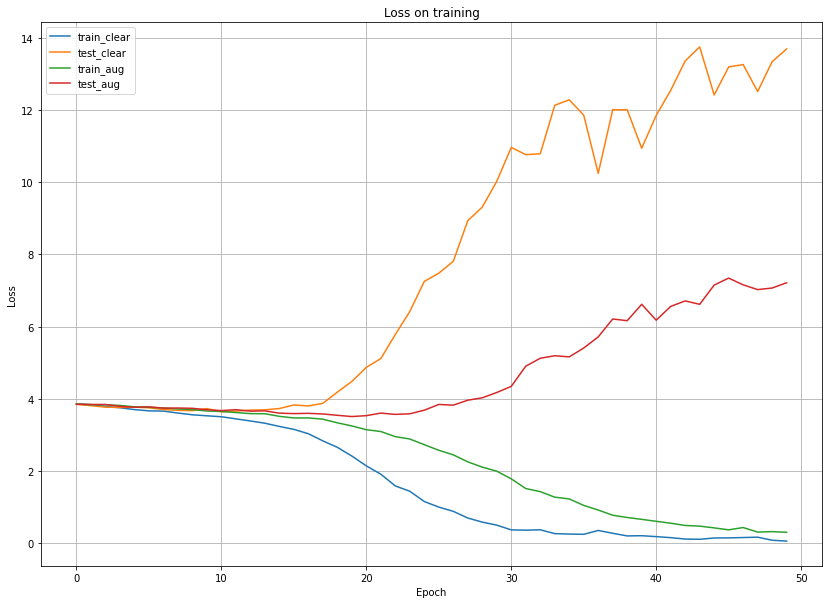

In [21]:
plt.rcParams["figure.figsize"] = (14, 10)

ax = plt.figure().gca()
ax.plot(history_clf_loss['train'])
ax.plot(history_clf_loss['test'])
ax.plot(history_clf_loss_aug['train'])
ax.plot(history_clf_loss_aug['test'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_clear', 'test_clear',
            'train_aug','test_aug'])
plt.grid()
plt.title('Loss on training')
plt.show();

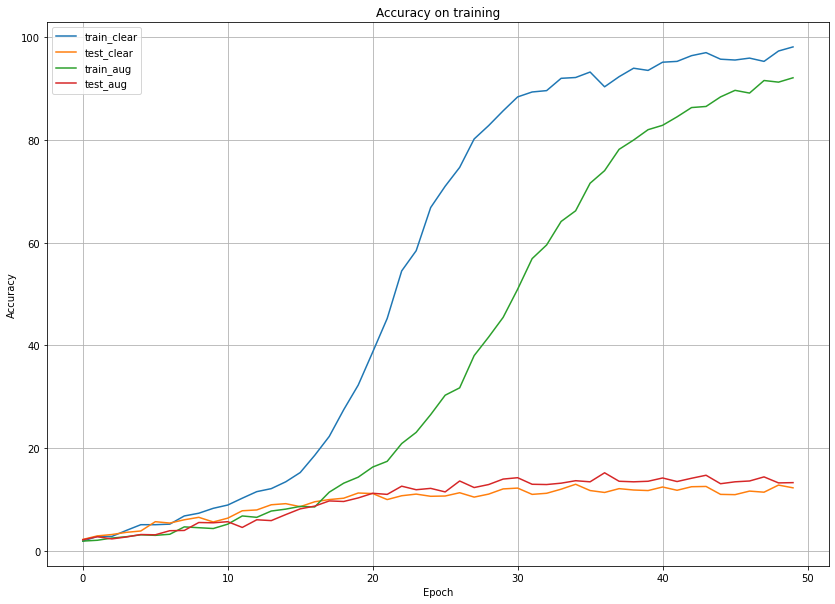

In [22]:
plt.rcParams["figure.figsize"] = (14, 10)

ax = plt.figure().gca()
ax.plot(history_clf_acc['train'])
ax.plot(history_clf_acc['test'])
ax.plot(history_clf_acc_aug['train'])
ax.plot(history_clf_acc_aug['test'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_clear', 'test_clear',
            'train_aug','test_aug'])
plt.grid()
plt.title('Accuracy on training')
plt.show();

## 1.7 Выводы
Что удалось попробовать? Что получилось, а что — нет? Повлияло ли добавление аугументации на качество?

В результате не удалось добиться хорошей точности на тестовых данных.  Аугментация данных не дала улучшения точности.

# 2. Рекуррентная нейронная сеть для генерации текстов (9 баллов)

## 2.1 Загрузка данных



In [26]:
text_data = str()
with open("L_war_and_piece.txt", 'r', encoding='utf-8') as file:
  for line in file.readlines():
    if len(line)<=25:
      continue
    text_data+=line.replace("\n", "")\
              .replace("       ", "\n")\
              .replace("   ",' ')\
              .replace("  ",' ')\
              .lower()
text_data=text_data[1:]

In [27]:
print(text_data[:1000])

в петербурге в это время в высших кругах, с большим жаром чем когда-нибудь, шла сложная борьба партий румянцева, французов, марии феодоровны, цесаревича и других, заглушаемая, как всегда, трубением придворных трутней. но спокойная, роскошная, озабоченная только призраками, отражениями жизни, петербургская жизнь шла по-старому; и из-за хода этой жизни надо было делать большие усилия, чтобы сознавать опасность и то трудное положение, в котором находился русский народ. те же были выходы, балы, тот же французский театр, те же интересы дворов, те же интересы службы и интриги. только в самых высших кругах делались усилия для того, чтобы напоминать трудность настоящего положения. рассказывалось шепотом о том, как противоположно одна другой поступили, в столь трудных обстоятельствах, обе императрицы. императрица мария феодоровна, озабоченная благосостоянием подведомственных ей богоугодных и воспитательных учреждений, сделала распоряжение об отправке всех институтов в казань, и вещи этих заведе

## 2.2 Преодбработка/нормализация данных по необходимости

Например, можно привести все слова к нижнему регистру

In [28]:
char_cnt = Counter(text_data)
char_cnt = sorted(char_cnt.items(), key = lambda ch: ch[1], reverse = True)
char_dict = {ch[0]: i for i, ch in enumerate(char_cnt)}
index_dict = {i: ch for ch, i in char_dict.items()}
text_data_num = np.array([char_dict[ch] for ch in text_data])

In [29]:
len(char_dict)

98

In [30]:
def get_batch(text_index,batch_size=32):
    data = list()
    result = list()
    for i in range(batch_size):
        first_s = np.random.randint(0,len(text_index) - 256)
        last_s = first_s + 256
        input = torch.LongTensor(text_index[first_s:last_s - 1]).view(-1, 1)
        output = torch.LongTensor(text_index[first_s + 1:last_s]).view(-1, 1)
        data.append(input)
        result.append(output)

    return torch.stack(data, dim=0), torch.stack(result, dim=0)

## 2.3 Инициализация объекта рекуррентной нейронной сети

In [31]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, embedding_size, n_layers):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.n_layers = n_layers

        self.embeding = nn.Embedding(self.input_size, self.embedding_size)
        self.rnn = nn.RNN(self.embedding_size, self.hidden_size, self.n_layers)
        self.dropout = nn.Dropout(0.2)

        self.linear1=nn.Linear(self.hidden_size,self.hidden_size//2)
        self.linear2=nn.Linear(self.hidden_size//2,self.input_size)
        
    def forward(self, x, hidden):
        x = self.embeding(x).squeeze(2)
        x, hidden = self.rnn(x, hidden)
        x = self.dropout(x)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x, hidden
    
    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=False).to(DEVICE)

In [32]:
rnnNet=RNN(len(char_dict),128,256,4).to(DEVICE)

## 2.4 Обучение обычной рекуррентной нейронной сети

In [33]:
def test_model(model, text,char_dict, length, T):
    x = torch.LongTensor([char_dict[ch] for ch in text]).view(-1, 1, 1).to(DEVICE)
    model.eval()
    with torch.no_grad():
        hidden = model.init_hidden(1)
        hidden = model.forward(x, hidden)[1]
        x = x[-1].view(-1, 1, 1)
        for i in range(length):
            y_pred, hidden = model.forward(x, hidden)
            y_pred = y_pred.cpu().data.view(-1)
            prob = F.softmax(y_pred / T, dim=-1).detach().cpu().data.numpy()
            index = np.random.choice(len(char_dict), p=prob)
            text += index_dict[index]
            x = torch.LongTensor([index]).view(-1, 1, 1).to(DEVICE)
    return text

def train_model(model, text_index,batch_size, criterion, optimizer, n_epoch):
    train_loss_list = list()
    for epoch in range(n_epoch):
      model.train()
      optimizer.zero_grad()
      x_batch, y_batch = get_batch(text_index,batch_size)
      x_batch = x_batch.permute(1, 0, 2).to(DEVICE)
      y = y_batch.permute(1, 0, 2).to(DEVICE)
      hidden = model.init_hidden(batch_size)
      
      y_pred = model.forward(x_batch, hidden)[0]
      loss = criterion(y_pred.permute(1, 2, 0), y.squeeze(-1).permute(1, 0))

      loss.backward()
      optimizer.step()

      train_loss_list.append(loss.item())

      if epoch % 200 == 0:
        print('___________________________________________________')
        print('Epoch: {epoch}'.format(epoch=epoch))
        print('Train loss: {train_loss}'.format(train_loss=train_loss_list[-1]))
    return model.eval(),train_loss_list

In [34]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnnNet.parameters(), lr=0.01, amsgrad=True)
rnnNet,rnn_loss_list = train_model(rnnNet,text_data_num,16,criterion,optimizer,n_epoch=10000)

___________________________________________________
Epoch: 0
Train loss: 4.6014556884765625
___________________________________________________
Epoch: 200
Train loss: 2.22931170463562
___________________________________________________
Epoch: 400
Train loss: 2.0239572525024414
___________________________________________________
Epoch: 600
Train loss: 1.8974883556365967
___________________________________________________
Epoch: 800
Train loss: 1.8377057313919067
___________________________________________________
Epoch: 1000
Train loss: 1.862819790840149
___________________________________________________
Epoch: 1200
Train loss: 1.8388049602508545
___________________________________________________
Epoch: 1400
Train loss: 1.9065070152282715
___________________________________________________
Epoch: 1600
Train loss: 1.8145946264266968
___________________________________________________
Epoch: 1800
Train loss: 1.7907211780548096
___________________________________________________
Epoch: 2

## 2.5 Генерация текстов при помощи обычной рекуррентной сети

In [35]:
input_text='гостиная анны павловны начала понемногу наполняться. приехала высшая знать петербурга, люди самые разнородные по возрастам и характерам, но'
for t in TEMPERATURE:
    pred_text = test_model(rnnNet,input_text,char_dict,250,t)
    print('_____________________________________________________________________________________________')
    print('T =',t)
    print(pred_text)

_____________________________________________________________________________________________
T = 0.1
гостиная анны павловны начала понемногу наполняться. приехала высшая знать петербурга, люди самые разнородные по возрастам и характерам, ноб по толо пода оло не не по под не сто вого по не на на на сон  то прени воо то сто ве пото про не сто во не на на не вого не во прени подна не во не на сто прен на не не сто ве по про то во вого на ст по пре не по на на пото не посто тазал е то про 
_____________________________________________________________________________________________
T = 0.2
гостиная анны павловны начала понемногу наполняться. приехала высшая знать петербурга, люди самые разнородные по возрастам и характерам, ноб сто бал на стазали прото так на толо пово на таза на не д сто посто ото и  то бо под не на по ото на сто не с ото иро та толо сто ве стото ве сто с так сто тото вого ви солосто пранито сто и тогьни не сон стазала сто он  тоторо во сто так с то и то
________________

## 2.6 Обучение рекуррентной нейронной сети с LSTM-ячейками

In [36]:
class LSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, embedding_size, n_layers):
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.n_layers = n_layers

        self.embeding = nn.Embedding(self.input_size, self.embedding_size)
        self.lstm = nn.LSTM(self.embedding_size, self.hidden_size, self.n_layers)
        self.dropout = nn.Dropout(0.2)

        self.linear1=nn.Linear(self.hidden_size,self.hidden_size//2)
        self.linear2=nn.Linear(self.hidden_size//2,self.input_size)
        
    def forward(self, x, hidden):
        x = self.embeding(x).squeeze(2)
        x, (hidden, cell) = self.lstm(x, hidden)
        x = self.dropout(x)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x, (hidden, cell)
    
    def init_hidden(self, batch_size):
        hidden=torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=False).to(DEVICE)
        cell=torch.zeros(self.n_layers, batch_size, self.hidden_size, requires_grad=False).to(DEVICE)
        return (hidden, cell)

In [37]:
lstmNet=LSTM(len(char_dict),128,256,4).to(DEVICE)

In [38]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstmNet.parameters(), lr=0.01, amsgrad=True)
lstmNet, lstm_loss_list = train_model(lstmNet,text_data_num,16,criterion,optimizer,n_epoch=10000)

___________________________________________________
Epoch: 0
Train loss: 4.54965353012085
___________________________________________________
Epoch: 200
Train loss: 3.240358352661133
___________________________________________________
Epoch: 400
Train loss: 2.416729211807251
___________________________________________________
Epoch: 600
Train loss: 2.1776859760284424
___________________________________________________
Epoch: 800
Train loss: 1.998457431793213
___________________________________________________
Epoch: 1000
Train loss: 1.9458056688308716
___________________________________________________
Epoch: 1200
Train loss: 1.828555703163147
___________________________________________________
Epoch: 1400
Train loss: 1.7176480293273926
___________________________________________________
Epoch: 1600
Train loss: 1.7371301651000977
___________________________________________________
Epoch: 1800
Train loss: 1.7337734699249268
___________________________________________________
Epoch: 2000

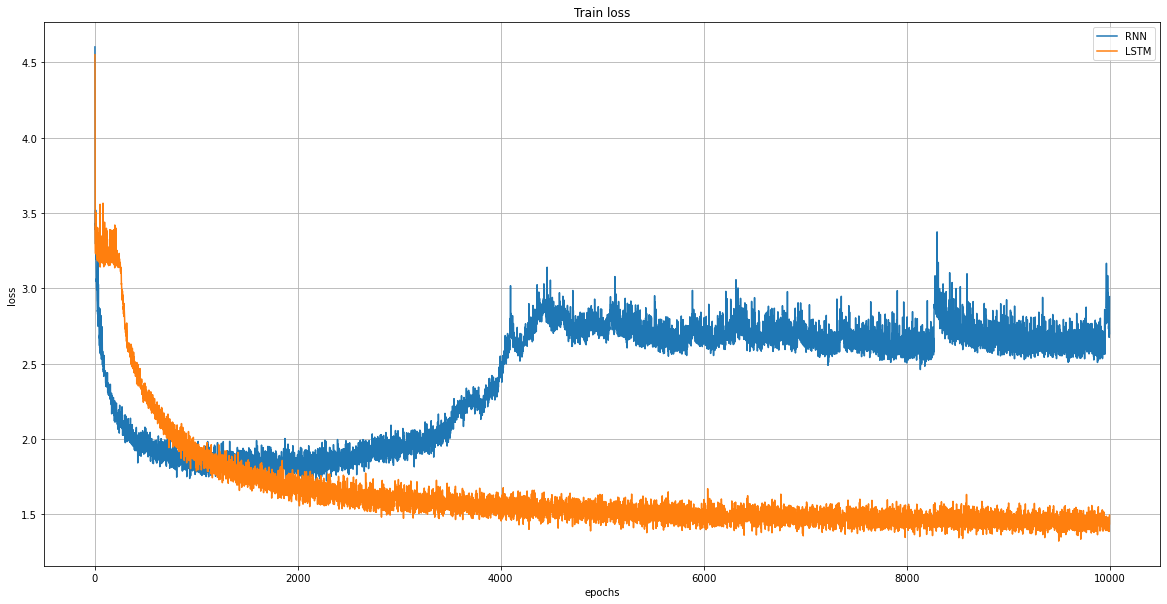

In [39]:
plt.figure(figsize=(20, 10))
plt.plot(rnn_loss_list)
plt.plot(lstm_loss_list)
plt.title("Train loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['RNN', 'LSTM'])
plt.grid()
plt.show()

## 2.7 Генерация текстов с разной температурой

Попробуйте сгенерировать тексты с температурой из списка: `[0.1, 0.2, 0.4, 0.6, 0.8, 1.0]` (см. нотубук с семинара по RNN)

In [40]:
input_text='гостиная анны павловны начала понемногу наполняться. приехала высшая знать петербурга, люди самые разнородные по возрастам и характерам, но'
for t in TEMPERATURE:
    pred_text = test_model(lstmNet,input_text,char_dict,250,t)
    print('_____________________________________________________________________________________________')
    print('T =',t)
    print(pred_text)

_____________________________________________________________________________________________
T = 0.1
гостиная анны павловны начала понемногу наполняться. приехала высшая знать петербурга, люди самые разнородные по возрастам и характерам, нобы и собралась и с своей стороны и совершенно подошла в своей представляли своей стороны и подошел к нему под собой и с своей день приказание и совершенно под случайность и прислали на своей стороны и не понял он собой и события и с тем как при своей
_____________________________________________________________________________________________
T = 0.2
гостиная анны павловны начала понемногу наполняться. приехала высшая знать петербурга, люди самые разнородные по возрастам и характерам, нобы под представление и солдаты и с котором он под него и подошел к нему в себе под первый силы и подошел к нему с ним и под смерти в своим событиями и в своей представляли и последние сражение с восторженно положение и под него в своей стороны и был 
________________

## 2.8 Выводы

Были испробованы две архитектуры НС с использование рекурентных НС.
Архитектуры отличаются только рекурентым слоем. 
1ая модель - обычная RNN
2ая модель - LSTM.
Все гиперпараметры моделей одиннаковые. Это было сделано, чтобы была видна разница в качестве предсказанного текста.

Модель с LSTM слоями генерирует текст немного лучше обычной модели. Она смогла собрать буквы в осмысленные слова и словосочетания.

При генерациюи текста в зависимости от температуры можно заметить, что чем выше температура, тем более длинные слова генерует модель.